In [1]:
import torch.nn as nn
import torch
from tqdm.notebook import tqdm 
import torchvision.models as models
import numpy as np
import json
from PIL import Image
from transformers import AdamW
import os
import torch.utils.data as data
from pycocotools.coco import COCO
from torchvision import transforms
import pytorch_lightning as pl
%matplotlib inline
import matplotlib.pyplot as plt 
import gym
#from multiprocessing_env import SubprocVecEnv
#from tqdm import tqdm
from torch.distributions.categorical import Categorical
from IPython.display import clear_output

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
BertModel = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased').to(device)
BertModel.eval()

Using cache found in C:\Users\lycan/.cache\torch\hub\huggingface_pytorch-transformers_master


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        for p in self.resnet.parameters():
            p.requires_grad = False
    def forward(self, images):
        out = self.resnet(images)
        # batch_size, img size, imgs size, 2048
        out = out.permute(0, 2, 3, 1)
        return out #[2, 7,7, 2048]

In [4]:
class mydataset(data.Dataset):
    def __init__(self, root, json,tokenizer, transform=None):
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.tokenizer = tokenizer
        self.transform = transform
    def __getitem__(self, index):
        coco = self.coco
        tokenizer = self.tokenizer
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        token_ids = tokenizer.encode(caption, add_special_tokens=True)
        tokens_tensor = torch.tensor(token_ids)
        return image.to(device), tokens_tensor.to(device)
    def __len__(self):
        return len(self.ids)
encoder = Encoder().to(device)
encoder.eval()
def collate_fn(data):
    data.sort(key=lambda  x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    lengths = torch.tensor([len(cap) for cap in captions])
    lengths, sort_ind = lengths.sort(dim=0, descending=True)
    sort_ind=[i.item() for i in sort_ind]
    img = torch.stack(images, 0)
    img = img[sort_ind]
    with torch.no_grad():
        img = encoder(img)
    Captions=[]
    for i in range(len(captions)):
        time = int(torch.ceil(max(lengths)/lengths[i]).item())
        Captions.append(captions[i].expand((time,captions[i].shape[-1])).flatten()[:max(lengths)])
    inputs = torch.stack(Captions, 0)    
    inputs = inputs[sort_ind]
    return img[:,0,0,:], inputs#[2, 14, 14, 2048]
def get_loader(method, tokenizer, batch_size):
    if method == 'train':
        root = 'D:\\yolodataset\\coco\\train2017'
        json = 'D:\\yolodataset\\coco\\annotations\\captions_train2017.json'
        shuffle = True
    else:
        root = 'D:\\yolodataset\\coco\\val2017'
        json = 'D:\\yolodataset\\coco\\annotations\\captions_val2017.json'
        shuffle = False
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
    coco = mydataset(root=root, json=json, tokenizer = tokenizer, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset=coco,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=0,
                                              collate_fn=collate_fn)
    return data_loader

In [5]:
batch_size = 64
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased') 
train_loader = get_loader('train', tokenizer, batch_size)
val_loader = get_loader('val', tokenizer, batch_size)
weight=torch.ones(tokenizer.vocab_size)
weight[0]=1e-6
#criterion = nn.CrossEntropyLoss(weight=weight,ignore_index=0).to(device)
criterion = nn.CrossEntropyLoss().to(device)

Using cache found in C:\Users\lycan/.cache\torch\hub\huggingface_pytorch-transformers_master


loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [6]:
class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim,embed_dim):

        super(Attention, self).__init__()
        self.att1 = nn.Linear(encoder_dim, decoder_dim)
        self.att2 = nn.Linear(embed_dim, decoder_dim)
        
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights
        self.imgattk = nn.Linear(decoder_dim, decoder_dim)
        self.imgattq = nn.Linear(decoder_dim, decoder_dim)
        self.embattk = nn.Linear(embed_dim, decoder_dim)
        self.embattq = nn.Linear(embed_dim, decoder_dim)

    def forward(self, imgs,h, embeddings):#b,decode_dim
        att1 = self.att1(imgs)
        att2 = self.att2(embeddings)
        imgs = att1*self.softmax(att1*h)
        embeddings = att2*self.softmax(att2*h)
        imgQ = self.imgattq(imgs)
        imgK = self.imgattk(imgs)
        embeddingsQ = self.embattq(embeddings)
        embeddingsK = self.embattk(embeddings)
        imgs = imgs*self.softmax(embeddingsQ*imgK)
        embeddings = embeddings*self.softmax(embeddingsK*imgQ)
        return torch.cat([embeddings, imgs], dim=1)


In [7]:
class Decoder(nn.Module):
    def __init__(self, tokenizer):
        super(Decoder, self).__init__()
        self.encoder_dim = 2048
        self.embed_dim = 768
        self.decoder_dim = 768
        self.vocab_size = tokenizer.vocab_size
        self.dropout = 0.5     
        self.Dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(self.decoder_dim*2, self.decoder_dim)
        self.h_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.c_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.fc = nn.Linear(self.decoder_dim, self.vocab_size)
        self.attention = Attention(self.encoder_dim, self.decoder_dim,self.embed_dim)
        
    def forward(self, imgs, tokens_tensor):#[b,2048]
        batch_size = imgs.size(0)
        max_dec_len = tokens_tensor.size(-1)
        encoder_dim = imgs.size(-1)
        vocab_size = self.vocab_size
        # init hidden state  
        h = self.h_lin(imgs)
        c = self.c_lin(imgs)
        Logits = torch.zeros(batch_size,max_dec_len,vocab_size).to(device)
        for i in range(max_dec_len):
            with torch.no_grad():
                embeddings = BertModel(tokens_tensor[:,i].unsqueeze(1).to(device))[0][:,0,:]
            input=self.attention(imgs,h,embeddings)
            h,c =self.decode_step(input,(h, c))
            Logits[:,i,:] = self.fc(self.Dropout(h))
        return Logits

In [8]:
def beam(img,max_len=40,n=5):
    with torch.no_grad():
        imgs = encoder(img.unsqueeze(0))[:,0,0,:]
        imgs = imgs.expand((n,-1))
        h = EDnet.decoder.h_lin(imgs)
        c = EDnet.decoder.c_lin(imgs)
        tt = torch.zeros(n, max_len,dtype = torch.long).to(device)
        tt[:,0]=101
    #initialize probability
    prob={i:1 for i in range(n)}
    for i in range(1,max_len):
        cand = {}
        with torch.no_grad():
            embeddings = BertModel(tt[:,i-1].unsqueeze(1).to(device))[0][:,0,:]
            input=EDnet.decoder.attention(imgs,h,embeddings)
            h, c = EDnet.decoder.decode_step(input,(h, c))#n,dim
            logits = EDnet.decoder.fc(h)#n,vs
        probs =nn.Softmax(dim=1)(logits)
        for j in range(n):
            tops = torch.topk(probs[j], n)
            for k in range(n):
                cand[prob[j]*tops[0][k].item()] = (j,tops[1][k].item())
        p=list(cand.keys())
        p.sort(reverse=True)
        prob = {i:p[i] for i in range(n)}
        temp = torch.zeros(n, max_len,dtype = torch.long).to(device)
        for j in range(n):
            og,addon = cand[prob[j]]
            temp[j] = tt[og]
            temp[j,i] = addon
        tt = temp
    return tt[0]

In [9]:
class network(pl.LightningModule):
    def __init__(self,tokenizer=tokenizer,lr = 4e-4):
        super().__init__()
        self.vocab_size=tokenizer.vocab_size
        self.decoder = Decoder(tokenizer).to(device)
        self.lr = lr
    def forward(self,imgs,token_tensor):
        self.decoder.eval()
        logits = self.decoder(imgs,token_tensor[:,:-1])
        return logits
    def training_step(self, batch, batch_idx):
        self.decoder.train()
        img, inputs = batch
        logits = self.decoder(img,inputs[:,:-1])
        logits = logits.view((-1,logits.shape[-1]))
        loss = criterion(logits,inputs[:,1:].flatten())
        return loss
    def configure_optimizers(self):
        optimizer = AdamW(params=self.decoder.parameters(),lr=self.lr)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 1e3, eta_min = 1e-4)
        return ({'optimizer': optimizer,'scheduler': sched,'interval': 'step','frequency': 50})
    def validation_step(self, batch, batch_idx):
        self.decoder.eval()
        img, inputs = batch
        with torch.no_grad():
            logits = self.decoder(img,inputs[:,:-1])
        pred = torch.argmax(logits,dim=-1)
        acc = (inputs[:,1:]==pred).float().mean()
        self.log('accuracy', acc, prog_bar=True)
        return acc

In [10]:
EDnet = network().to(device)
EDnet = EDnet.load_from_checkpoint('C:\\Users\\lycan\\Documents\\cu\\nlp\\4705\\hw5\\lightning_logs\\att17e-1.ckpt')
trainer = pl.Trainer(gpus=1,max_epochs=3, progress_bar_refresh_rate=100)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [11]:
def greedy(imgs,max_len=40):
    EDnet.decoder.eval()
    encoder_dim = 768
    with torch.no_grad():
        imgs = encoder(imgs.unsqueeze(0))[:,0,0,:]
        h = EDnet.decoder.h_lin(imgs) 
        c = EDnet.decoder.c_lin(imgs) 
        tt = torch.zeros(1, max_len,dtype = torch.long).to(device)
        tt[0,0]=101
    for i in range(1,max_len):
        with torch.no_grad():
            embeddings = BertModel(tt[:,i-1].unsqueeze(1).to(device))[0][:,0,:]
            input=EDnet.decoder.attention(imgs,h,embeddings)
            h,c =EDnet.decoder.decode_step(input,(h, c))
            logits = EDnet.decoder.fc(h)[0] 
            tt[0,i]=torch.argmax(logits)
    return tt[0]

In [12]:
def translator(tt):
    tt=tokenizer.convert_ids_to_tokens(tt)
    end = len(tt)-1
    if '.' in tt and '[SEP]' in tt:
        end = min(tt.index('.'),tt.index('[SEP]'))
    elif '[SEP]' in tt:
        end = tt.index('[SEP]')
    elif '.' in tt:
        end = tt.index('.')
    tt= tt[:end]
    tt = [i for i in tt if i not in ['[CLS]','[PAD]']]
    tt=tokenizer.convert_tokens_to_string(tt)
    return tt

In [13]:
root = 'D:\\yolodataset\\coco\\val2017'
json = 'D:\\yolodataset\\coco\\annotations\\captions_val2017.json'
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
coco = mydataset(root=root, json=json, tokenizer = tokenizer, transform=transform)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [14]:
EDnet=EDnet.to(device)
EDnet.eval()
def vslz(cap1,capg= None,capb = None,img=None):
    transform = transforms.Compose([
                transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225),(1/0.229, 1/0.224, 1/0.225))])
    img = transform(img)
    plt.imshow(img.permute(1,2,0))
    plt.show()
    if capg is not None:
        print('greedy: ',capg)
    if capb is not None:
        print('beam: ',capb)
    print('true_cap: ',cap1)

In [15]:
def random_test(n = 5):
    for _ in range(n):
        index = np.random.randint(len(coco))
        img,tt = coco[index]
        cap = translator(tt.to(device))
        tt = greedy(img.to(device))
        pred1 = translator(tt)
        tt = beam(img,n = 1)
        pred2 = translator(tt)
        vslz(cap1=cap,capg= pred1,capb= pred2,img=img.cpu())
        

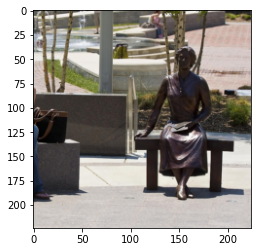

greedy:  a woman sitting on a bench with a suitcase
beam:  a woman sitting on a bench with a suitcase
true_cap:  a woman sitting on a bench next to a statue sitting on a bench


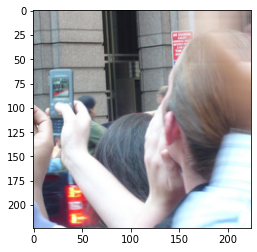

greedy:  a woman is talking on a cell phone
beam:  a woman is talking on a cell phone
true_cap:  people at a public event using cell phones to take pictures of the event


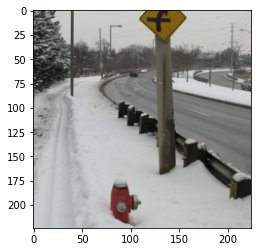

greedy:  a street sign is shown on a snowy snow covered hill
beam:  a street sign is shown on a snowy snow covered hill
true_cap:  a red fire hydrant sitting on the side of a road


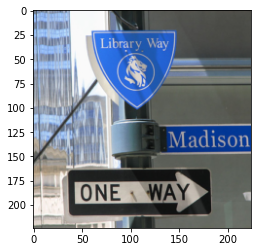

greedy:  a street sign with a street sign on it
beam:  a street sign with a street sign on it
true_cap:  the black street pole has three different signs on it


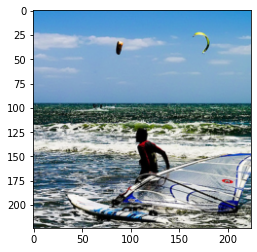

greedy:  a man is surfing in the ocean with a kite
beam:  a man is surfing in the ocean with a kite
true_cap:  several para - gliders can be seen in the blue sky


In [16]:
random_test(5)

In [17]:
vocab_size = tokenizer.vocab_size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
encoder = encoder.to(device)
BertModel = BertModel.to(device)
class imcp(gym.Env):

    def __init__(self,img,tt,max_len,EDnet=EDnet,BertModel=BertModel):
        self.EDnet = EDnet
        self.BertModel = BertModel
        self.max_len = max_len
        self.state = self.reset(EDnet,img,tt)
    @torch.no_grad()
    def reset(self,EDnet,img,tt):
        self.previous_action = torch.tensor(101)
        self.tt = tt
        self.counter = 0
        self.done = 0
        self.reward = 0
        self.img = encoder(img.unsqueeze(0))[:,0,0,:]
        self.state = self.EDnet.decoder.h_lin(self.img)
        self.c = self.EDnet.decoder.c_lin(self.img)
        return self.state

    @torch.no_grad()
    def get_prob(self):
        token = self.previous_action
        try:
            embeddings = self.BertModel(token.unsqueeze(0).unsqueeze(0).to(device))[0][:,0,:]
        except:
            embeddings = self.BertModel(token.unsqueeze(0).to(device))[0][0,...]
        input=self.EDnet.decoder.attention(self.img,self.state,embeddings)
        self.state, self.c = self.EDnet.decoder.decode_step(input,(self.state, self.c))
        logits = self.EDnet.decoder.fc(self.state)
        probs =nn.Softmax(dim=1)(logits)[0]
        return probs
    @torch.no_grad()
    def step(self, action, dist): #(multiple actions issue)
        self.counter+=1
        ft_log_prob = dist.log_prob(action)
        pret_log_prob = torch.log(self.get_prob()[action])
        label = self.tt[self.counter%len(self.tt)]
        ft_log_prob_label = dist.log_prob(label)
        pret_log_prob_label = torch.log(self.get_prob()[label])
        same = 0
        if action == label:
            same = 1
        #self.reward = 10*same+ \
        #    torch.clamp(pret_log_prob+pret_log_prob_label, -10, 0)+ \
        #    2*torch.clamp(ft_log_prob+ft_log_prob_label, -10, 0)
        self.reward = torch.clamp(ft_log_prob_label, -10, 0)
        if action in [0,102]:
            self.done = 1 
        if self.counter == max_len-1:
            self.done = 1
        self.previous_action = action
        return [self.state, self.reward, self.done]

In [18]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
class ActorCritic(nn.Module):
    def __init__(self, obssize,actsize, hidden_size=512):
        super(ActorCritic, self).__init__()     
        self.critic = nn.Sequential(
            nn.Linear(obssize, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.actor = nn.Sequential(
            nn.Linear(obssize, actsize),
            nn.Softmax(dim = 1)
        )
        self.apply(init_weights) 
    def forward(self, state):
        value = self.critic(state)
        probs = self.actor(state)
        dist  = Categorical(probs = probs)        
        return dist, value

In [19]:
index = np.random.randint(len(coco))
img,tt = coco[index]
env = imcp(img,tt,30)
class network(nn.Module):
    def __init__(self,env=env,tokenizer=tokenizer):
        super().__init__()
        self.vocab_size=tokenizer.vocab_size
        self.ac = ActorCritic(768,self.vocab_size).to(device)
        self.ac.actor[0].weight.data = EDnet.decoder.fc.weight.data.clone()
        self.optimizer = torch.optim.Adam(params=self.ac.parameters(),lr=1e-3)
        self.env = env
    def compute_gae(self,rewards, masks, values, gamma=1, tau=1):
        gae = 0
        Qs = []
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
            gae = delta + gamma * tau * masks[step] * gae
            Qs.insert(0, gae + values[step])
        return torch.tensor(Qs).detach().to(device)
    def collecting(self,EDnet,num_img=16,traj_len = 30,gt = 1):
        log_probs = []
        values    = []
        states    = []
        actions   = []
        rewards   = []
        masks     = []
        for _ in range(num_img):
            index = np.random.randint(len(coco))
            img,tt = coco[index]
            state = self.env.reset(EDnet,img,tt)
            for i in range(1,traj_len):
                dist, value = self.ac(state)
                if gt:
                    action = tt[i%len(tt)]
                else:
                    action = dist.sample() 
                    
                log_prob = dist.log_prob(action)
                next_state,reward,done = self.env.step(action,dist)
                
                log_probs.append(log_prob)
                values.append(value)
                rewards.append(reward)
                masks.append(1 - done)
                #S = state.detach().clone()
                S = state.clone()
                states.append(S.unsqueeze(0))
                actions.append(action)
                
                state = next_state
                if done == 1:
                    break
        _, next_value = self.ac(next_state)
        next_values = values+[next_value]
        #print(rewards, masks, next_values)
        log_probs = torch.tensor(log_probs).detach().to(device)
        values    = torch.tensor(values).detach().to(device)
        states    = torch.cat(states).to(device)
        actions   = torch.tensor(actions).to(device)
        Qs = self.compute_gae(rewards, masks, next_values)
        return states, actions, log_probs, values, Qs
    def ppo_iter(self,mini_batch_size, samples):
        states, actions, log_probs, values, Qs = samples
        batch_size = Qs.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = np.random.randint(0, batch_size, mini_batch_size)
            yield states[rand_ids,:], actions[rand_ids], log_probs[rand_ids], values[rand_ids], Qs[rand_ids]
    @torch.no_grad()
    def forward(self,EDnet,tt,img,traj_len = 30):
        actions = []
        state = self.env.reset(EDnet,img,tt)
        for i in range(1,traj_len):
            dist, value = self.ac(state)
            action = dist.sample() 
            next_state,reward,done = self.env.step(action,dist)
            actions.append(action)
            state = next_state
            if done == 1:
                break
        return torch.tensor(actions).to(device)
    def training_step(self, batch,gt):
        states, actions, old_log_probs, Values, Qs = batch
        dist, values = self.ac(states)
        entropy = dist.entropy().mean()
        new_log_probs = dist.log_prob(actions)
        advantage = Qs-Values
        ratio = (new_log_probs - old_log_probs).exp()
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 0.8, 1.2) * advantage

        actor_loss  = - torch.min(surr1, surr2).mean()
        critic_loss = (Qs - values).pow(2).mean()
        #loss =  critic_loss +actor_loss - 1e-5*entropy
        loss =  0.5*critic_loss +actor_loss 
        return loss
    def train(self, epoch = 3000):
        LOSS=[]
        for i in tqdm(range(epoch)):
            if i<1500:
                gt = 1
            else:
                gt = 0
            samples = self.collecting(EDnet,num_img=128,traj_len = 30,gt = gt)
            data_loader = self.ppo_iter(mini_batch_size=64, samples=samples)
            for batch in data_loader:
                loss = self.training_step(batch,gt)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            if i%50==0:
                LOSS.append(loss.item())
                plt.plot(LOSS) 
                plt.show()

In [20]:
max_len = 30
decoder_trainer = network()
#decoder_trainer.ac.load_state_dict(torch.load('./attempt2.pth'))

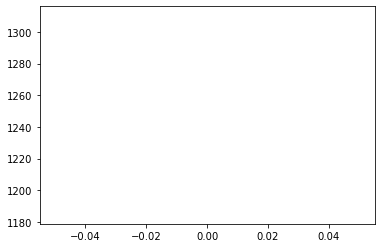

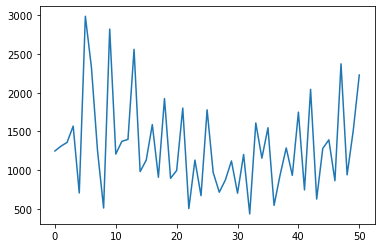

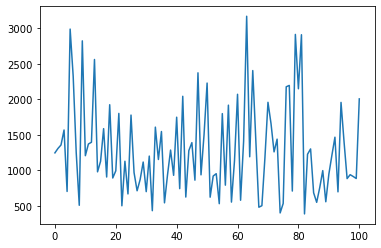

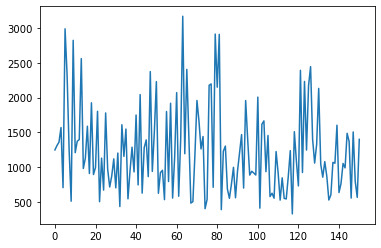

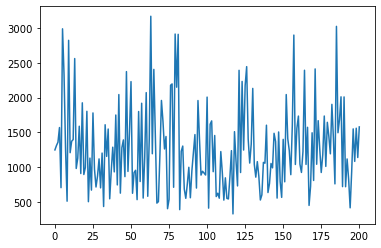

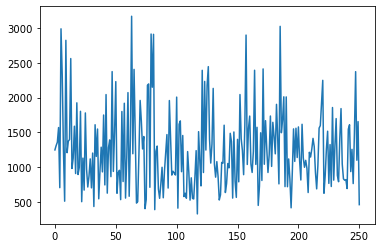

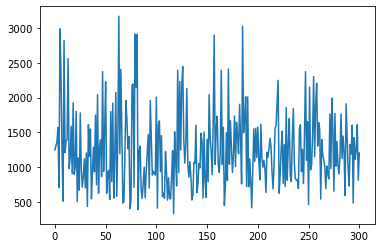

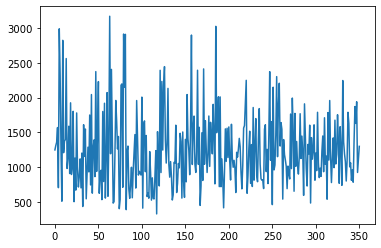

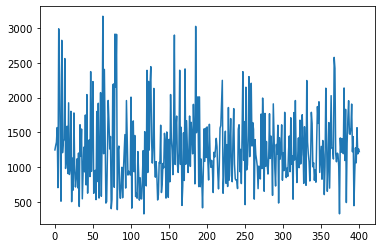

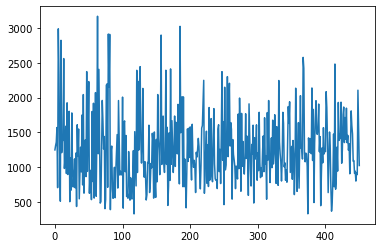

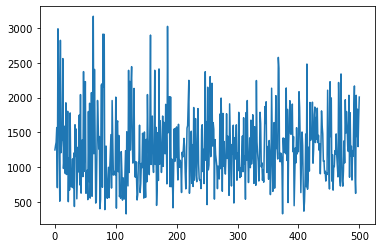

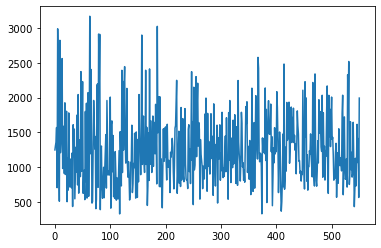

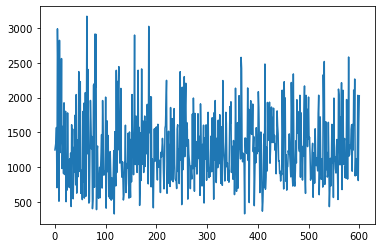

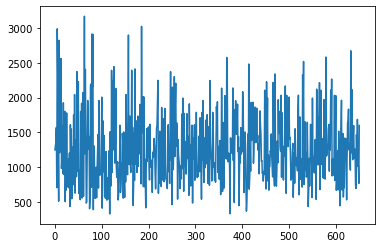

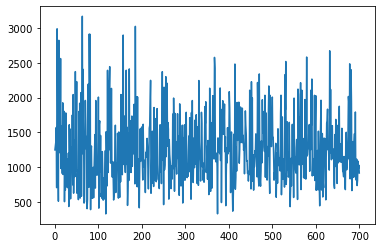

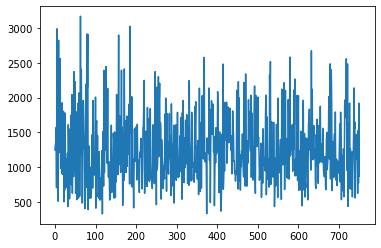

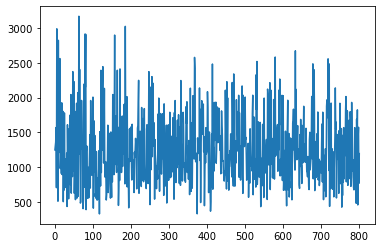

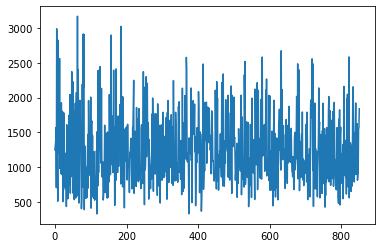

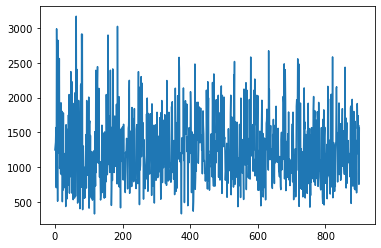

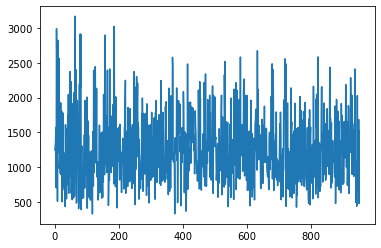

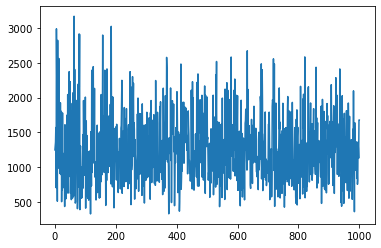

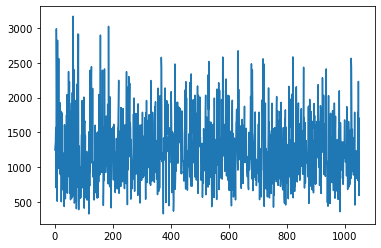

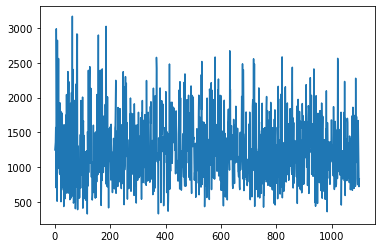

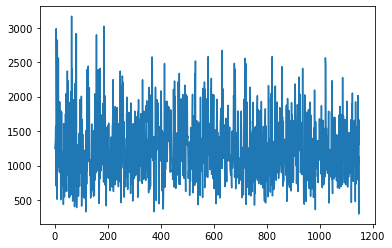

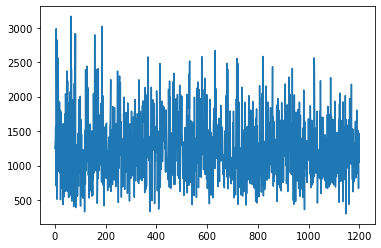

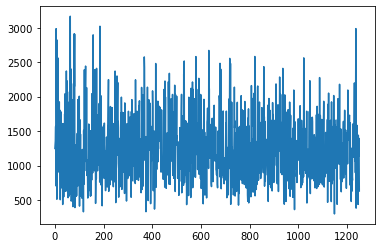

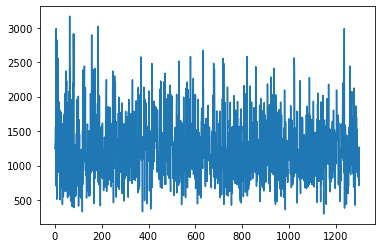

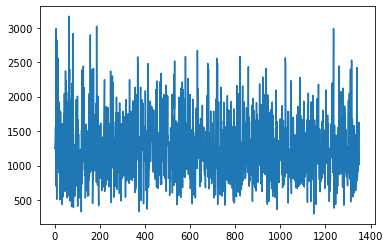

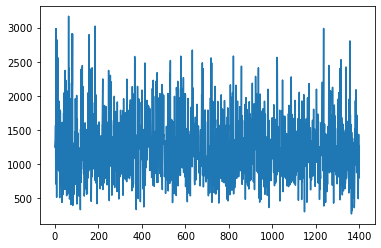

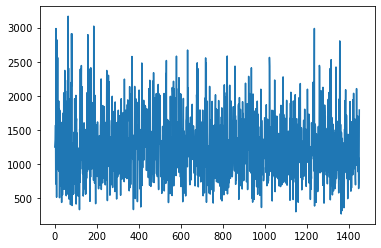

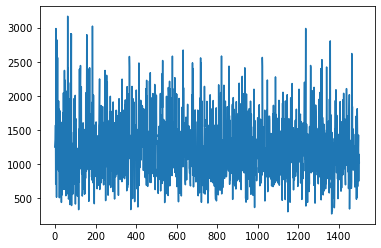

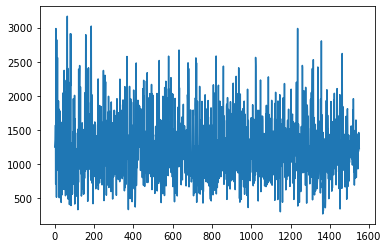

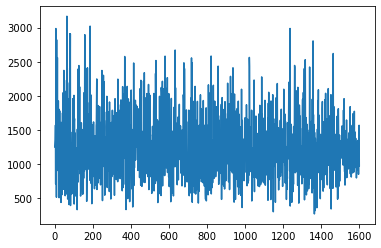

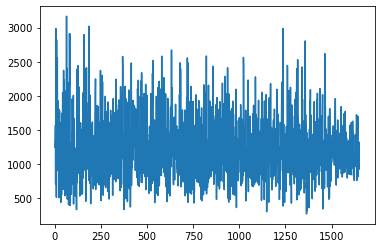

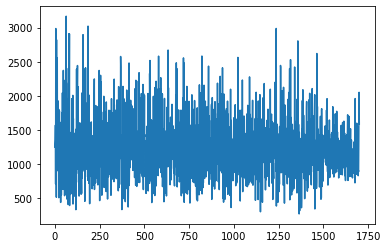

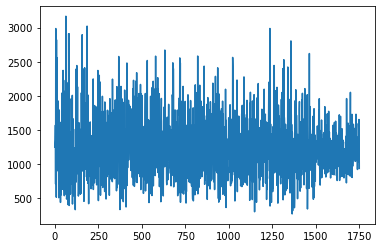

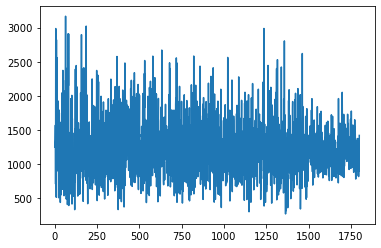

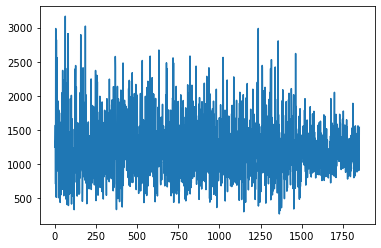

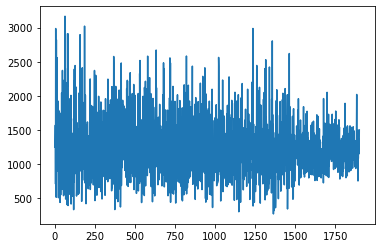

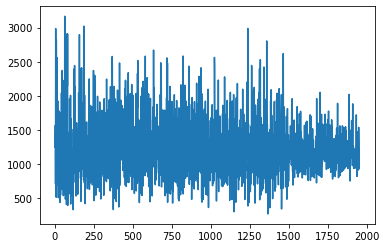

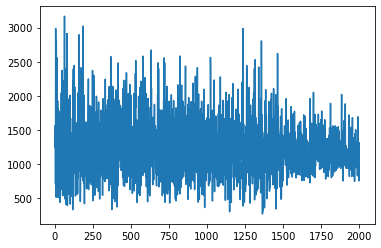

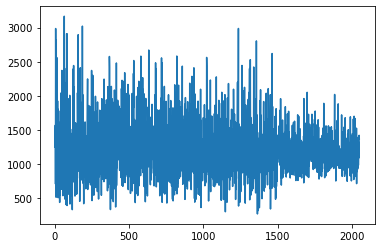

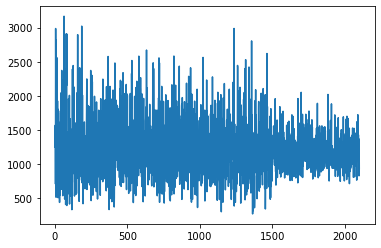

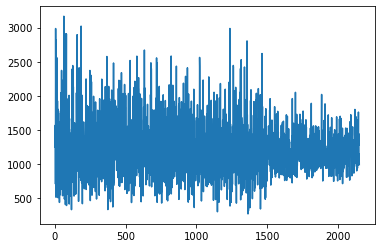

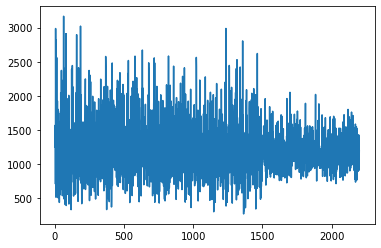

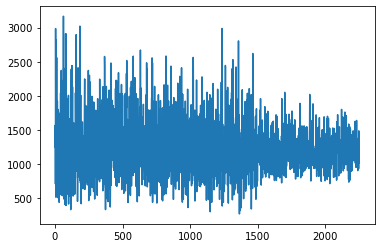

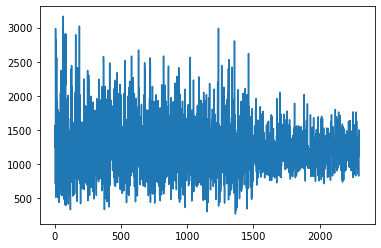

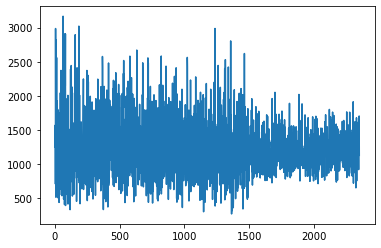

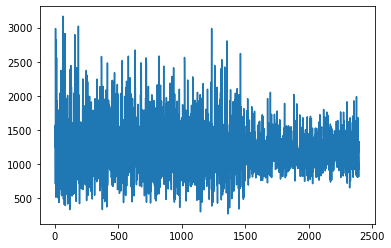

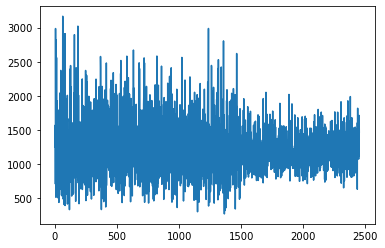

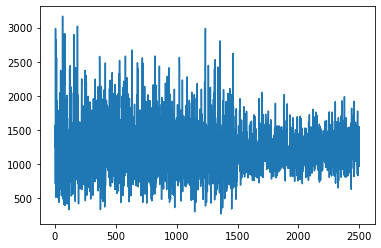

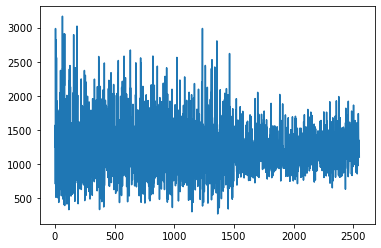

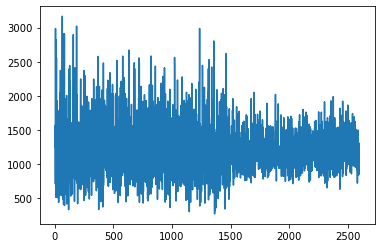

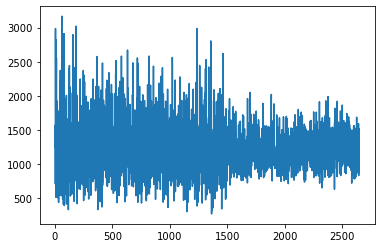

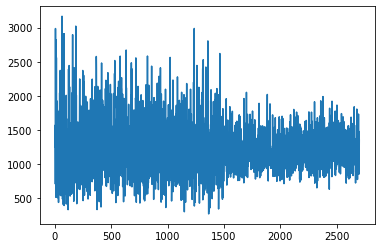

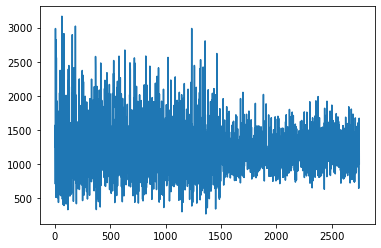

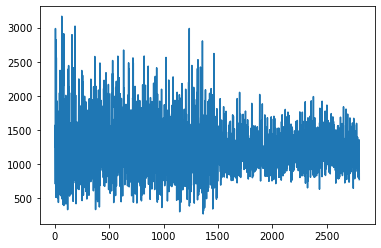

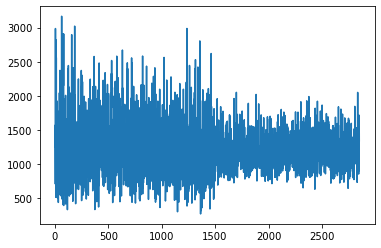

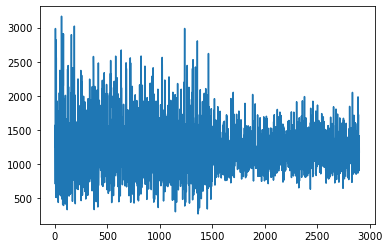

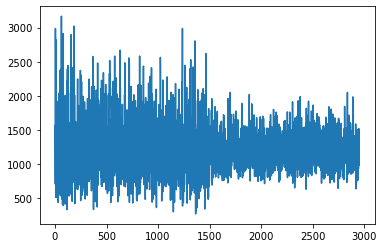

In [21]:
decoder_trainer.train()

In [22]:
torch.save(decoder_trainer.ac.state_dict(), './attempt2.pth')

In [23]:
def vis2(n=5):
    for _ in range(n):
        index = np.random.randint(len(coco))
        img,tt = coco[index]
        actions = decoder_trainer(EDnet,tt,img)
        tokens = tokenizer.convert_ids_to_tokens(actions)
        cap = tokenizer.convert_tokens_to_string(tokens)
        print(cap)
        transform = transforms.Compose([
                transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225),(1/0.229, 1/0.224, 1/0.225))])
        img = transform(img.cpu())
        plt.imshow(img.permute(1,2,0))
        plt.show()

##s hand holds laying against on sheets remote . ; [SEP]


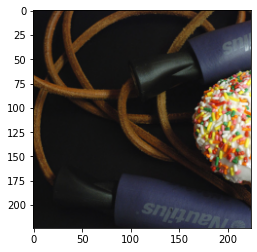

##s group has shows zebra with out heads ? while [SEP]


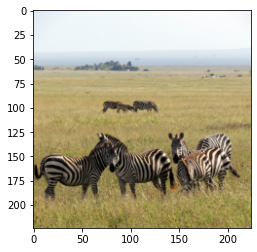

##s young are someone open watches making . . [SEP]


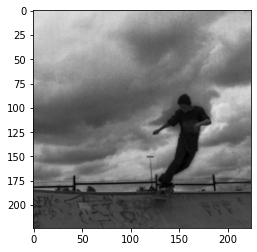

##s individual us andpt onds two look cars like stream stop around along traffic wrong like watching - [SEP]


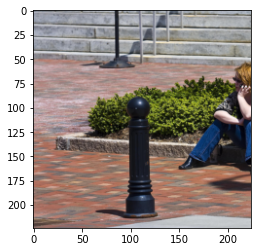

##s people is folded being and crew other . - [SEP]


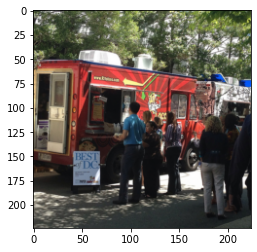

In [24]:
vis2()

In [25]:
index = np.random.randint(len(coco))
img,tt = coco[index]
actions = decoder_trainer(EDnet,tt,img)
actions

tensor([ 2015,  3080,  1005, 12191,  2111,  2015,  5948,  2007, 17860, 11640,
         2004,  1010,  2402,  2028,  3203,  3173,  1000,  4540,  1010,  3468,
         2028,  2000,  3138,  3806,  2060,  2013,  2012,  5551, 11640],
       device='cuda:0')

In [26]:
tokens = tokenizer.convert_ids_to_tokens(actions)
tokenizer.convert_tokens_to_string(tokens)

'##s older \' laptop peoples drinking with pillows phones as , young one lady holding " ear ,ble one to takes gas other from at ears phones'

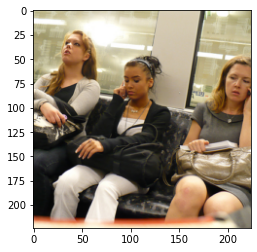

In [27]:
    transform = transforms.Compose([
                transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225),(1/0.229, 1/0.224, 1/0.225))])
    img = transform(img.cpu())
    plt.imshow(img.permute(1,2,0))
    plt.show()

In [28]:
batch=decoder_trainer.collecting(EDnet,num_img=1,traj_len = 40,gt = 1)
states, actions, old_log_probs, Values, Qs = batch

In [29]:
_, actions, _, _, _ = decoder_trainer.collecting(EDnet,num_img=1,traj_len = 30,gt = 1)
actions

tensor([ 2304,  1998,  2317,  6302,  1997,  1037, 14334,  3902,  1999,  1037,
         9746,   102], device='cuda:0')

In [30]:
tokens = tokenizer.convert_ids_to_tokens(actions)
tokenizer.convert_tokens_to_string(tokens)

'black and white photo of a commuter bus in a warehouse [SEP]'

In [31]:
dist, values = decoder_trainer.ac(states)

In [32]:
dist.log_prob(actions).shape

torch.Size([13, 12])

In [33]:
actions.shape

torch.Size([12])

In [34]:
states

tensor([[[ 4.8748e+01, -3.6905e-01, -2.3007e+01,  ...,  4.9589e+01,
          -8.6094e+01, -5.7351e+01]],

        [[-3.0608e-01,  6.4342e-04, -6.5295e-03,  ...,  7.2285e-01,
          -2.5126e-03, -5.4454e-02]],

        [[-8.4654e-02,  1.0546e-02,  4.8923e-03,  ...,  4.0975e-01,
          -8.3573e-02,  8.7500e-03]],

        ...,

        [[ 3.9884e-02,  7.5316e-02,  2.9622e-02,  ...,  2.4545e-02,
          -6.0056e-02, -1.0575e-03]],

        [[-8.1467e-03,  2.6322e-02,  8.5318e-03,  ...,  5.1905e-01,
          -4.2224e-02,  1.6581e-03]],

        [[ 3.1331e-02,  1.9964e-01, -9.9595e-03,  ..., -4.4520e-04,
          -5.8074e-02, -5.3716e-03]]], device='cuda:0')

In [35]:
dist  = Categorical(states[0,40:])

In [36]:
[dist.log_prob(i).item() for i in actions]

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
P=[]
for i in range(len(actions)):
    action = actions[i]
    dist = Categorical(states[i,40:])
    L = dist.log_prob(action).item()
    P.append(L)
P

In [ ]:
len(actions)

In [ ]:
actions

In [ ]:
tokenizer.convert_ids_to_tokens(actions)

In [ ]:
old_log_probs

In [ ]:
index = np.random.randint(len(coco))
img,tt = coco[index]
state = decoder_trainer.env.reset(EDnet,img,tt)

In [ ]:
tt

In [ ]:
num_img = 5
traj_len = 20
gt = 0

In [ ]:
        log_probs = []
        values    = []
        states    = []
        actions   = []
        rewards   = []
        masks     = []
        for _ in range(num_img):
            index = np.random.randint(len(coco))
            img,tt = coco[index]
            state = decoder_trainer.env.reset(EDnet,img,tt)
            for i in range(1,traj_len):
                dist, value = decoder_trainer.ac(state)
                if gt:
                    action = tt[i%tt.shape[-1]]
                else:
                    action = dist.sample() 
                    
                log_prob = dist.log_prob(action)
                next_state,reward,done = decoder_trainer.env.step(action)
                
                log_probs.append(log_prob)
                values.append(value)
                rewards.append(reward)
                masks.append(1 - done)
                #S = state.detach().clone()
                S = state.clone()
                states.append(S)
                actions.append(action)
                
                state = next_state
                if done == 1:
                    break

In [ ]:
torch.cat([action,action])

In [ ]:
BertModel(torch.tensor(5).unsqueeze(0).unsqueeze(0).to(device))[0][:,0,:]

In [ ]:
states[1][0,2093,:]


In [ ]:
torch.argmax(states[1])

In [ ]:
m(dist.logits)

In [ ]:
state[40:]

In [ ]:
torch.sum(torch.exp(dist.logits))

In [ ]:
a = torch.tensor([(i-10.) for i in range(10)])
a

In [ ]:
a = torch.tensor([0]*10)
a

In [ ]:
m = torch.nn.Softmax()
m(a)

In [ ]:
dist  = Categorical(logits = a)
dist.logits

In [ ]:
dist.log_prob(dist.sample())

In [ ]:
dist.log_prob(dist.sample().unsqueeze(0))

In [ ]:
dist  = Categorical(logits = a)
dist.logits

In [ ]:
torch.log(a)

In [ ]:
state[40:]/torch.sum(state[40:])

In [ ]:
state[40:]/torch.sum(state[40:])

In [ ]:
torch.log(state[41])

In [ ]:
dist  = Categorical(probs = state[40:])
dist.log_prob(torch.zeros(1).to(device))

In [ ]:
torch.log(state[40])

In [ ]:
torch.sort(dist.logits)

In [ ]:
torch.sort(state[40:])

In [ ]:
dist  = Categorical(logits = state[40:])
dist.logits

In [ ]:
state[40:]

In [ ]:
a = "I resume the process!"
b = "The resume is attached!"
token_ida = tokenizer.encode(a, add_special_tokens=True)
token_idb = tokenizer.encode(b, add_special_tokens=True)
tokenizer.convert_ids_to_tokens(token_ida)

In [ ]:
tokenizer.convert_ids_to_tokens(token_idb)

In [ ]:
embeddinga = BertModel(torch.tensor(token_ida).unsqueeze(0).to(device))[0]
embeddinga

In [ ]:
embeddingb = BertModel(torch.tensor(token_idb).unsqueeze(0).to(device))[0]
embeddingb

In [ ]:
embeddinga[0,2]

In [ ]:
embeddingb[0,2]

In [ ]:
c = "a resume"
token_idc = tokenizer.encode(c, add_special_tokens=True)
embedding = BertModel(torch.tensor(token_idc).unsqueeze(0).to(device))[0]
embedding

In [ ]:
BertModel(torch.cat([action,action]).unsqueeze(0).to(device))[0][0,...].shape

In [ ]:
torch.cat([action,action]).shape

In [ ]:
BertModel(action.unsqueeze(0).to(device))[0][:,0,:].shape

In [ ]:
BertModel(torch.tensor(action).unsqueeze(0).to(device))

In [ ]:
torch.tensor(action)

In [ ]:
def foo(x = 894):
    symbol = ['M','D','C','L','X','V','I']
    unit = [1000,500,100,50,10,5,1]
    output = []
    if x >= 1000:
        return 'M'
    for i in [1,3,5]:
        mod = x%unit[i] #894
        multi = x//unit[i] #0
        if multi>1:
            output.append(symbol[i-1])
        elif multi == 1 and (x+unit[i+1])%unit[i]==2:
            output.append(symbol[i+1])
            output.append(symbol[i-1])
        elif multi == 1 and (x+unit[i+1])%unit[i]==1:
            output.append(symbol[i])
            
        if mod != (x+unit[i+1])%unit[i]:
            
        multi = x//unit[i] #0
        next_multi = (10*output)%unit[i]
        if multi==0 and next_multi==9:
            output.append(symbol[i+2])
            output.append(symbol[i])
        elif next_multi<9:
            
            